# 1) Introduction


<h2>Where were thsoe parts that we relayed on third parties and API?</h2>

<!DOCTYPE html>
<html>
<head>
    <title>Bullet Points Example</title>
</head>
<body>
    <ul style="font-size: 20px; margin: 20px;">
        <li>Building the Knowledge Graph
            <ul>
                <li>Previous solution: Diffbot API / GPT4-turbo</li>
                <li>Current local alternative: Simple python scrips running locally</li>
            </ul>
        </li>
        <li>Graph-DBMS
            <ul>
                <li>Previous solution: Cloud Neo4j</li>
                <li>Current local alternative: Local Neo4j server</li>
            </ul>
        </li>
        <li>PAPTOR RAG architecture (in generating summary of clusters)
            <ul>
                <li>Previous solution: GPT3 API</li>
                <li>Current local alternative: Local Mistral</li>
            </ul>
        </li>
        <li>Embeddings of docs stored in VectorDB
            <ul>
                <li>Previous solution: OpenAIEmbeddings</li>
                <li>Current local alternative: Local nomic-ai embeddings</li>
            </ul>
        </li>
        <li>Generating Cypher query
            <ul>
                <li>Previous solution: GPT3 API </li>
                <li>Current local alternative: Local Mistral</li>
            </ul>
        </li>
        <li>Q&A and chat LLM
            <ul>
                <li>Previous solution: GPT3 API</li>
                <li>Current local alternative: Local Mistral</li>
            </ul>
        </li>
    </ul>
<br>
<br>
<br>
</body>
</html>


# 2) Project Management

<h2>2.1) First of all, as an ordinary person, why should I care about privacy of my data?</h2>

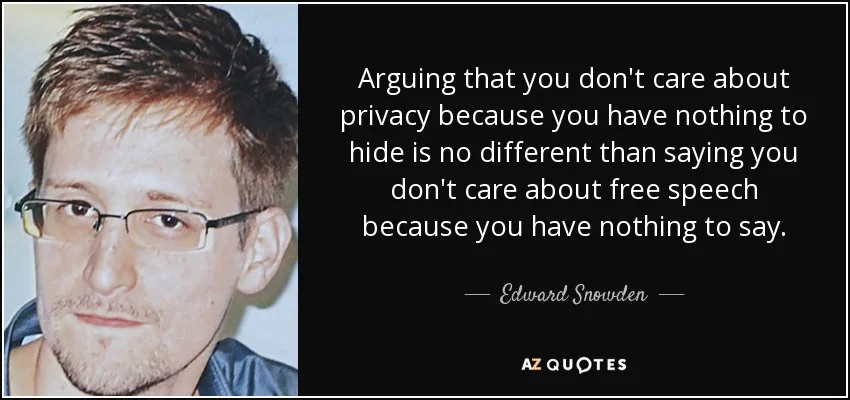

<pr>Photo from the internet</pr>

<h2>2.2) What could be the consequences of not caring? Isn't this lovely that these big tech companies are taking out the dirty works and give us a nice API?</h2>

# 3) Env Setup

In [19]:
!echo $CONDA_PREFIX 
# >> /opt/anaconda3/envs/chatbot # This means we are using the correct conda environment

/opt/anaconda3/envs/chatbot


In [8]:
!pip install langchain==0.2.3 langchain_experimental==0.0.60 langchain_community==0.2.4 langchain-openai==0.1.8 langchainhub==0.1.20 langchain-anthropic==0.1.15 
!pip install umap-learn==0.5.6 scikit-learn==1.2.2 tiktoken==0.7.0 chromadb==0.5.0 wikipedia==1.4.0 openai==1.31.0
!pip install beautifulsoup4 lxml # for scraping and parsing
!pip install neo4j==5.21.0 # for neo4j backend connection 
!pip install streamlit==1.35.0 
# !npm install localtunnel # we don't need this locally

!pip install matplotlib
# !pip install ipywidgets==8.1.3 # python input() was not working on my jupyter. ipywidgets was an alternative

In [9]:
!pip install numpy==1.26.4

In [10]:
!touch requirements_Inventures_local_Improved_KG_RAG_with_UI.txt
# pip freeze on Google Colab

In [11]:
!pip freeze >> requirements_Inventures_local_Improved_KG_RAG_with_UI.txt

In [90]:
# %%writefile mylibs.py 
# Importing libraries
import os
import pickle
import json # saving sessions data in a json file
# from google.colab import userdata # for importing env variable on Colab
import matplotlib.pyplot as plt
import tiktoken # for counting the # of tokens in each document
import numpy as np
import pandas as pd
import umap # for dimensionality reduction
from sklearn.mixture import GaussianMixture # for clustering
from typing import Dict, List, Optional, Tuple # for type hinting

from bs4 import BeautifulSoup # for scraping and parsing

# Wikiloader in case we want to retrieve data from Wikipedia as a trainset
from langchain_community.document_loaders import WikipediaLoader
# converting doc_text files into langchain document objects
from langchain.docstore.document import Document

from langchain_openai import OpenAIEmbeddings # For text-to-vector
from langchain_openai import ChatOpenAI # For API call to LLM
from langchain_anthropic import ChatAnthropic # Alternative to OpenAI LLM

from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

RANDOM_SEED = 307  # Fixed seed for reproducibility of clustering

from langchain_community.vectorstores import Chroma #In-memory VectorDB

from langchain import hub # Langchain Hub for RAG prompt templates
# placeholder used in chain
from langchain_core.runnables import RunnablePassthrough
import streamlit as st



#### Knowledge Graph imports
from langchain_experimental.graph_transformers.diffbot import DiffbotGraphTransformer
from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain

from langchain_core.messages import HumanMessage, SystemMessage
from openai import OpenAI

# Make sure to `pip install openai` first
embedding_server = OpenAI(base_url="http://localhost:1234/v1/", api_key="lm-studio")

class TrueOpenAIEmbeddings:
    def __init__(self, model="nomic-ai/nomic-embed-text-v1.5-GGUF/resolve/main/nomic-embed-text-v1.5.Q8_0.gguf"):
        self.model_type = model

    def embed_query(self, text):
        # print(f"inside embed sigle and input is {text}")
        text = text.replace("\n", " ")
        response = embedding_server.embeddings.create(input=[text], model=self.model_type)
        return response.data[0].embedding

    def embed_documents(self, texts):
        # print(f"inside embed documents and input is {texts}")
        return [self.embed_query(d) for d in texts]

Overwriting mylibs.py


In [ ]:
# Args and global variables
# not needed anymore
# os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
# os.environ["ANTHROPIC_API_KEY"] = 'anthropic-api-key'

In [22]:
# Chat with an intelligent assistant in your terminal

# Point to the local server
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

history = [
    {"role": "system", "content": "You are an intelligent assistant. You always provide well-reasoned answers that are both correct and helpful."},
    {"role": "user", "content": "Hello, introduce yourself to someone opening this program for the first time. Be concise."},
]

run = True
while True:
    completion = client.chat.completions.create(
        model="TheBloke/Mistral-7B-Instruct-v0.2-GGUF",
        messages=history,
        temperature=0,
        stream=True,
    )

    new_message = {"role": "assistant", "content": ""}
    
    for chunk in completion:
        if chunk.choices[0].delta.content:
            print(chunk.choices[0].delta.content, end="", flush=True)
            new_message["content"] += chunk.choices[0].delta.content

    history.append(new_message)

    print("\n\n\n") 

    user_input = "Please only return a query based on Cypher language that returns the whole graph. Do not write anything else other than the query."
    history.append({"role": "user", "content": user_input})
    if not run:
        break
    run = False

 Hello! I'm an intelligent assistant designed to help answer questions and provide useful information. I strive to give accurate and clear responses to make your experience as efficient and enjoyable as possible. Feel free to ask me anything!



 ```cypher
MATCH (a)-[r]-(b)
RETURN a, r, b```





# 4) Data Handeling

## 4.1 Scraping and parsing the data

In [25]:
def parse_sessions_html(html_file_add):
  # Read the HTML file
  with open(html_file_add, 'r', encoding='utf-8') as file:
    html_content = file.read()

  # Parse the HTML content using BeautifulSoup
  soup = BeautifulSoup(html_content, 'lxml')

  # Extract session details
  sessions = []
  session_divs = soup.find_all('div', attrs={"x-html": "session.card_template"})

  for session_div in session_divs:
    session = {}

    # Extract session category
    category_tag = session_div.find('span', class_="block w-fit bg-green py-2 -mt-1 md:ml-0 px-6 lg:pr-8 text-xs font-moderna rounded-br-full")
    session['category'] = category_tag.text.strip() if category_tag else None

    # Extract session title
    title_tag = session_div.find('h2', class_="font-moderna uppercase text-base xl:text-lg text-purple")
    session['title'] = title_tag.text.strip() if title_tag else None

    # Extract session description
    description_tag = session_div.find('div', class_="cursor-pointer text-base line-clamp-2")
    session['description'] = description_tag.text.strip() if description_tag else None

    # Extract speakers
    speakers = []
    speaker_section = session_div.find('div', class_="md:border-t border-slate-200 md:pt-4")
    if speaker_section:
      speaker_buttons = speaker_section.find_all('button', class_="group relative flex gap-4 justify-start items-center !no-underline")
      for speaker_button in speaker_buttons:
        speaker = {}

        # Extract speaker name
        name_tag = speaker_button.find('h4', class_="text-sm font-moderna")
        speaker['name'] = name_tag.text.strip() if name_tag else None

        # Extract speaker position
        position_tag = speaker_button.find('p', class_="override text-sm leading-tight text-slate-500")
        speaker['position'] = position_tag.text.strip() if position_tag else None

        speakers.append(speaker)

    session['speakers'] = speakers
    sessions.append(session)

  sessions.pop(0) # The first session is empty
  # Convert the sessions list to a JSON string
  json_string = json.dumps(sessions)
  # Write the JSON string to a file
  with open('sessions.json', 'w') as f:
    f.write(json_string)

  return sessions


## 4.2) Processing data

In [26]:
def save_sessions_to_text_files(sessions):
    """Save sessions to a separate text files."""
    for i, session in enumerate(sessions, start=1):
      category = session['category']
      title = session['title']
      description = session['description']
      speakers = session['speakers']
      content = f"A session under the category of : {category} which is titled as: {title} is held at Inventures. The description of this session is: {description}. \n "

      if speakers:
        content += "The speakers of this session are: \n"
      for speaker in speakers:
        name = speaker['name']
        position = speaker['position']
        content += f"  - Name: {name} who has a position: {position}\n"

      content += "\n"

      with open(f"./sessions_txt/{i}.txt", "a", encoding='utf-8') as file:
        file.write(content)
        file.close()

# 5) Modeling

In [27]:
# Reference for this cell:
# https://github.com/langchain-ai/langchain/blob/master/cookbook/

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """
    Give a detailed summary of the documentation provided.

    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results


# 6) Evaluation

In [28]:
# We're using human evaluation on different aspects of automatic text
# summarization and question answering

# 7) Deployment & Maintnance

In [ ]:
!unzip sessions_txt.zip

## 7.0) Setting up improved graph database

In [56]:
# Set up the connection
uri = "bolt://localhost:7687"
username = "neo4j"
password = "password"

graph = Neo4jGraph(url=uri, username=username, password=password)

In [45]:
def create_constraints(graph):
    graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:Category) REQUIRE c.name IS UNIQUE")
    graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (sp:Speaker) REQUIRE sp.name IS UNIQUE")
    graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (co:Company) REQUIRE co.name IS UNIQUE")

# Create the constraints
create_constraints(graph)

In [46]:
def extract_speaker_info(data):
  if data == "":
    return "", ""
  if " at " in data:
    position, organization = data.split(" at ")[:2]
    return position, organization
  return data, ""

In [47]:
def clear_database(graph):
    # Cypher query to delete all nodes and relationships
    query = """
    MATCH (n)
    DETACH DELETE n
    """
    # Execute the query
    graph.query(query)

In [48]:
# Call the function to clear the database
clear_database(graph)

In [53]:
def add_data_to_neo4j(graph, session, session_index):
  # Create or match the category
  # print(session_index)
  graph.query("""
  MERGE (c:Category {name: $category_name})
  """, {'category_name': session['category']})

  # Create the session and connect to category
  graph.query("""
  MATCH (c:Category {name: $category_name})
  MERGE (s:Session {title: $title, description: $description, index: $index})
  MERGE (s)-[:SESSION_BELONGS_TO]->(c)
  """, {'category_name': session['category'], 'title': session['title'], 'description': session['description'], 'index': session_index})

  # Add speakers
  for speaker in session.get('speakers', []):
    speaker_name = speaker['name']
    position, organization = extract_speaker_info(speaker.get('position', None))


    # Create or match the speaker
    graph.query("""
    MERGE (sp:Speaker {name: $speaker_name})
    ON CREATE SET sp.position = $position
    """, {'speaker_name': speaker_name, 'position': position})

    # Step 1: Create or match the Company (if organization exists)
    if organization:
      graph.query("""
      MERGE (co:Company {name: $company_name})
      """, {'company_name': organization})

    # Step 2: Connect the Speaker to the Company (assuming both nodes exist)
    # Check again to ensure organization exists
    if organization:
      graph.query("""
      MATCH (sp:Speaker {name: $speaker_name}), (co:Company {name: $company_name})
      MERGE (sp)-[:SPEAKER_WORKS_IN]->(co)
      """, {'speaker_name': speaker_name, 'company_name': organization})


    # Connect the speaker to the session
    graph.query("""
    MATCH (s:Session {title: $title, index: $index})
    MATCH (sp:Speaker {name: $speaker_name})
    MERGE (s)-[:SESSION_HAS_SPEAKER]->(sp)
    """, {'title': session['title'], 'index': session_index, 'speaker_name': speaker_name})
  


In [57]:
import json

with open("sessions.json", "r") as f:
    sessions_json = json.load(f)

In [59]:
graph.query("""MATCH (n) RETURN n LIMIT 5""")

[{'n': {'name': 'Registration'}},
 {'n': {'description': 'Badge collection is available in the Exhibition Hall Foyer area of the convention centre. This is for delegates who have registered online and purchased a ticket for Inventures in advance using our online registration system.\xa0  STUDENTS AND MEDIA: Badge collection for students and media is available at the kiosk window/counter just inside the ground-level entrance to the convention centre North Building, just beyond the convention centre information desk. Student ID or Media Accreditation must be shown to collect your badge.  ONSITE TICKET PURCHASE:\u202fIf you need to purchase a ticket onsite, we encourage you to use the online registration link available on the Inventures 2024 website using your smartphone or laptop. You can then pick up your badge at registration. Should you require assistance with the onsite purchase of tickets, please visit the kiosk window/counter just inside the ground-level entrance to the convention 

In [55]:
# Iterate through the JSON data and add it to the database
for idx, session in enumerate(sessions_json):
    add_data_to_neo4j(graph, session, idx)
print("Done. Enjoy working with the graph representation of your data!")

Done. Enjoy working with the graph representation of your data!


In [8]:
graph.refresh_schema()

In [60]:
print(graph.get_schema)

Node properties:
Category {name: STRING}
Speaker {name: STRING, position: STRING}
Company {name: STRING}
Session {title: STRING, description: STRING, index: INTEGER}
Relationship properties:

The relationships:
(:Speaker)-[:SPEAKER_WORKS_IN]->(:Company)
(:Session)-[:SESSION_BELONGS_TO]->(:Category)
(:Session)-[:SESSION_HAS_SPEAKER]->(:Speaker)


## 7.1) RAG codes

In [61]:
doc_text = [] # loading the txt files into a list of strings
for i in range(1,187):
  with open(f'./sessions_txt/{i}.txt', 'r') as file:
    data = file.read()
    doc_text.append(data)

In [62]:
raw_documents = []
for i in range(len(doc_text)):
  raw_documents.append(Document(page_content=doc_text[i], metadata={"source": "local", 'id':i+1}))

In [63]:
# Make sure to `pip install openai` first
embedding_server = OpenAI(base_url="http://localhost:1234/v1/", api_key="lm-studio")

class TrueOpenAIEmbeddings:
    def __init__(self, model="nomic-ai/nomic-embed-text-v1.5-GGUF/resolve/main/nomic-embed-text-v1.5.Q8_0.gguf"):
        self.model_type = model

    def embed_query(self, text):
        # print(f"inside embed sigle and input is {text}")
        text = text.replace("\n", " ")
        response = embedding_server.embeddings.create(input=[text], model=self.model_type)
        return response.data[0].embedding

    def embed_documents(self, texts):
        # print(f"inside embed documents and input is {texts}")
        return [self.embed_query(d) for d in texts]


In [64]:
# Create an instance of TrueOpenAIEmbeddings
embd = TrueOpenAIEmbeddings()

# Embed documents
embeddings = embd.embed_documents(["Once upon a time, there was a cat.","Once upon a time, there there two cats."])
print(embeddings)

[[0.03201862424612045, 0.06339021772146225, -0.1485486477613449, -0.07495227456092834, 0.05322074145078659, 0.033833447843790054, -0.08443336933851242, 0.04095049947500229, -0.02298538014292717, 0.006490843836218119, -0.002983804326504469, 0.03710930421948433, 0.07530467212200165, 0.03950362652540207, -0.0714140310883522, -0.07569345086812973, 0.03581097722053528, -0.03519176319241524, 0.023282308131456375, 0.05217181146144867, -0.00028215660131536424, -0.03402334824204445, 0.06201495602726936, 0.02758781984448433, 0.036768924444913864, 0.05156147480010986, -0.04705529287457466, 0.04728596284985542, -0.013939945958554745, 0.011553875170648098, 0.019041266292333603, -0.025938358157873154, 0.0067710867151618, -0.040290094912052155, -0.01611078716814518, -0.037975434213876724, 0.07615136355161667, 0.014948222786188126, 0.04871078208088875, 0.05761585757136345, 0.028663964942097664, 0.038389578461647034, -0.04174976795911789, -0.008329471573233604, 0.04929797723889351, 0.02317655086517334,

In [65]:
# embd = OpenAIEmbeddings() # we don't need this anymore. We are using a local truely open embedding model :)
# model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo", max_tokens=4096)
# model = ChatAnthropic(temperature=0, model="claude-3-opus-20240229")
model = ChatOpenAI(temperature=0, base_url="http://localhost:1234/v1", api_key="lm-studio")

In [66]:
# Testing models capability in summarization on a part of David Goggins <3 wikipedia page 
template = """
Give a detailed summary of the documentation provided.

Documentation:
{context}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()
test_doc = """
Goggins was born on February 17, 1975, to Trunnis and Jackie Goggins. In 1981, he lived in Williamsville, New York, on a street called Paradise Road with his parents and brother, Trunnis Jr.[8] While Goggins's neighborhood held "model citizens consisting of white people," he describes his home experience as "hell on Earth."[9] Goggins's father owned the roller skating rink Skateland, located in East Buffalo, New York. At age six, Goggins often worked the night shift at Skateland alongside his family, organizing roller skates.[8] Goggins’s mother left his father due to abuse and eventually moved herself and her children to live with Goggins's grandparents in Brazil, Indiana. Goggins enrolled in second grade at a small Catholic school and made First Communion.[10] His brother, Trunnis Jr., returned to Buffalo to live with their father.[11] When Goggins enrolled in the third grade, he was diagnosed with a learning disability due to the lack of schooling.[9] He also found it difficult to learn as he was suffering from toxic stress because of the child abuse that he suffered during his early years in Buffalo, New York. Because of the stress, he developed a stutter. Goggins explains how he was constantly in a fight-or-flight response with social anxiety because of his stuttering.[9] In school, Goggins was subjected to racism and the Ku Klux Klan held a local presence at the time in Brazil, Indiana.[9] Goggins recalls he once found "Niger [sic] we're gonna kill you" on his Spanish notebook. At 16, a student spray painted "nigger" on the door of Goggins's car.[11] Before his freshman year, Goggins attended a pararescue jump orientation course. Goggins's grandfather had served in the Air Force before him and prompted him to attend.[11]
"""
# Format text within each cluster for summarization
summaries = []
summaries.append(chain.invoke({"context": test_doc}))

In [136]:
num_tokens_from_string(test_doc, "cl100k_base")

415

In [68]:
print(summaries[0])

 The documentation provides an account of the early life experiences of David Goggins, a renowned ultra-endurance athlete and retired U.S. Navy SEAL. Born on February 17, 1975, in Williamsville, New York, Goggins grew up in a challenging environment with his parents and brother, Trunnis Jr. His neighborhood was predominantly white, but he describes his home life as "hell on Earth." His father owned Skateland, a roller skating rink in East Buffalo, where young Goggins often worked long hours alongside his family.

When Goggins's mother left his abusive father, she took the children to live with their grandparents in Brazil, Indiana. In second grade, Goggins enrolled at a small Catholic school and made his First Communion. However, he was diagnosed with a learning disability due to the lack of formal education and the toxic stress caused by the child abuse he suffered during his early years in Buffalo. This resulted in a stutter, which caused him significant social anxiety.

Goggins also

In [69]:
leaf_texts = doc_text

In [70]:
type(leaf_texts), len(leaf_texts)

(list, 186)

In [ ]:
# Build document tree
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

In [71]:
# prompt: unpickle results.pkl into results
with open("results.pkl", "rb") as f:
    results = pickle.load(f)

In [ ]:
# # prompt: pickle results
# # Choose a filename for the pickle file
# pickle_file = "results.pkl"

# # Open the pickle file for writing in binary mode
# with open(pickle_file, "wb") as f:
#     # Use pickle.dump to serialize the results dictionary into the file
#     pickle.dump(results, f)

In [32]:
# Initialize the tokenizer
tokenizer = tiktoken.get_encoding("cl100k_base")

# Function to count the number of tokens in a string
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

cnt = [num_tokens_from_string(d, "cl100k_base") for d in doc_text]

In [33]:
# Doc texts concatenated all articles
d_sorted = sorted(raw_documents, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content1 = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content1, "cl100k_base")
)

Num tokens in all context: 35941


In [34]:
35941 / 36

998.3611111111111

In [113]:
results[3][1]

,summaries,level,cluster
0,The documentation provided offers a detailed s...,3,0


In [72]:
# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [37]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing (joining all docs retrieved after vector search)
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)


In [73]:
# Question
query = "Tell me about the topics discussed at Inventures"
rag_ans = rag_chain.invoke(query)
print(rag_ans)

 The Inventures conference covers various topics including technology, innovation, entrepreneurship, and policy. Sessions are categorized into themes such as Networking, Entrepreneurship, Blurring Boundaries, and Featured. Topics discussed range from global collaborations to Indigenous entrepreneurship, environmental sustainability, and shaping the future of different sectors and regions. Speakers are experts in their fields, emphasizing collaboration, sustainability, innovation, and social impact.


In [74]:
# Question
query2 = "How many sessions did Laura Kilcrease participated in?"
rag_ans2 = rag_chain.invoke(query2)
rag_ans2

' Laura Kilcreas participated in at least two sessions at Inventures, one under the category of "Blurring Boundaries" titled "Four Generations of Farming, Food & Family: Dame Sheila Barry Driscoll on Innovation, Legacy, and Leadership," and another under the category of "Featured" titled as "Closing Ceremony."'

In [49]:
query3 = "How many sessions were held?"
rag_ans3 = rag_chain.invoke(query3)
rag_ans3

' Based on the context provided, five sessions were held at this event under the category of "Blurring Boundaries" and another three sessions under the category of "Live Long, Live Well: Unveiling Health Data." Therefore, a total of eight sessions were held at the Inventures event.'

## 7.2) Knowledge Graph codes

In [75]:
# Set up the connection
uri = "bolt://localhost:7687"
username = "neo4j"
password = "password"

graph = Neo4jGraph(url=uri, username=username, password=password)

In [146]:
is_graph_already_built = True
if not is_graph_already_built:
  # load Diffbot Token for later entity and relationship extraction
  os.environ["DIFFBOT_API_KEY"] = userdata.get('DIFFBOT_TOKEN')
  diffbot_nlp = DiffbotGraphTransformer(diffbot_api_key=os.environ["DIFFBOT_API_KEY"])
  # use Diffbot Graph Transformer to extract entities/relationships from Wikipedia articles
  graph_documents = diffbot_nlp.convert_to_graph_documents(raw_documents)
  # import extracted entities and relationships into neo4j graph database
  graph.add_graph_documents(graph_documents)

In [ ]:
# # Save the graph documents to a pickle file
# with open('inventures_graph_documents.pkl', 'wb') as f:
#   pickle.dump(graph_documents, f)

with open("inventures_graph_documents.pkl", "rb") as f:
  graph_documents = pickle.load(f)

In [ ]:
graph_documents[6]

GraphDocument(nodes=[Node(id='David Sweeney', type='Person', properties={'name': 'David Sweeney', 'positionHeld': 'Professor'}), Node(id='http://www.wikidata.org/entity/Q223429', type='Organization', properties={'name': 'University of Birmingham'}), Node(id='http://www.wikidata.org/entity/Q6833913', type='Person', properties={'name': 'Michael Robertson'}), Node(id='http://www.wikidata.org/entity/Q640694', type='Organization', properties={'name': 'University of Alberta'}), Node(id='http://www.linkedin.com/in/jacqueline-wilson-smith-1222595', type='Person', properties={'name': 'Jacqueline Wilson-Smith', 'positionHeld': 'Director & Strategic Facilitator'}), Node(id='http://www.wikidata.org/entity/Q1117048', type='Organization', properties={'name': 'CSIRO'}), Node(id='Sustainable Innovation Co.', type='Organization', properties={'name': 'Sustainable Innovation Co.'})], relationships=[Relationship(source=Node(id='David Sweeney', type='Person'), target=Node(id='http://www.wikidata.org/entity

In [ ]:
type(graph_documents), type(graph_documents[0])

(list, langchain_community.graphs.graph_document.GraphDocument)

In [76]:
print(graph.schema)

Node properties:
Category {name: STRING}
Speaker {name: STRING, position: STRING}
Company {name: STRING}
Session {title: STRING, description: STRING, index: INTEGER}
Relationship properties:

The relationships:
(:Speaker)-[:SPEAKER_WORKS_IN]->(:Company)
(:Session)-[:SESSION_BELONGS_TO]->(:Category)
(:Session)-[:SESSION_HAS_SPEAKER]->(:Speaker)


In [77]:
# Quering the graph dataset
result = graph.query("MATCH (n) RETURN n LIMIT 1")
print(result)

[{'n': {'name': 'Registration'}}]


In [ ]:
# # Manually printing the schema
# # Retrieve node labels
# node_labels_query = "MATCH (n) RETURN DISTINCT labels(n) AS labels"
# node_labels_result = graph.query(node_labels_query)
# node_labels = [record['labels'][0] for record in node_labels_result]  # assuming single label per node

# # Retrieve node properties
# node_properties = {}
# for label in node_labels:
#   properties_query = f"""
#   MATCH (n:{label})
#   RETURN DISTINCT keys(n) AS properties
#   """
#   properties_result = graph.query(properties_query)
#   properties = set()
#   for record in properties_result:
#       properties.update(record['properties'])
#   node_properties[label] = list(properties)

# # Retrieve relationship types
# relationship_types_query = "MATCH ()-[r]->() RETURN DISTINCT type(r) AS relationshipType"
# relationship_types_result = graph.query(relationship_types_query)
# relationship_types = [record['relationshipType'] for record in relationship_types_result]

# # Retrieve relationship properties
# relationship_properties = {}
# for rel_type in relationship_types:
#   properties_query = f"""
#   MATCH ()-[r:{rel_type}]->()
#   RETURN DISTINCT keys(r) AS properties
#   """
#   properties_result = graph.query(properties_query)
#   properties = set()
#   for record in properties_result:
#       properties.update(record['properties'])
#   relationship_properties[rel_type] = list(properties)

# # Print the schema in the specified format
# print("Node properties:")
# for node_type, properties in node_properties.items():
#   print(f"{node_type}: {properties}")

# print("\nRelationship properties:")
# for relationship_type, properties in relationship_properties.items():
#   print(f"{relationship_type}: {properties}")

# print("\nThe relationships:")
# for relationship in relationship_types:
#   print(relationship)

In [78]:
cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm=model,
    qa_llm=model,
    graph=graph,
    verbose=True,
    return_intermediate_steps=True
)

In [79]:
kg_query1 = "Who are the people working at the same company as Laura Kilcrease does??"
kg_answer = cypher_chain.invoke(kg_query1)
print("\n\nFinal kg answer:\n\n")
kg_answer



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (s:Speaker)-[:SPEAKER_WORKS_IN]->(c:Company)
WHERE s.name = 'Laura Kilcrease'
MATCH (p:Speaker)-[:SPEAKER_WORKS_IN]->(c)
RETURN p.name

Full Context:
[{'p.name': 'Dr. Sunil Rajput'}, {'p.name': 'Dr. Zhihong (John) Zhou'}, {'p.name': 'Mehr Nikoo'}, {'p.name': 'Doug Holt'}, {'p.name': 'Bruce Duong'}, {'p.name': 'Stephan Zuberec'}, {'p.name': 'Reesa John'}, {'p.name': 'Dr. Kathryn Graham'}, {'p.name': 'Matt Cornall'}, {'p.name': 'Tim Murphy'}]

> Finished chain.


Final kg answer:




{'query': 'Who are the people working at the same company as Laura Kilcrease does??',
 'result': ' The individuals listed in the information, Dr. Sunil Rajput, Dr. Zhihong (John) Zhou, Mehr Nikoo, Doug Holt, Bruce Duong, Stephan Zuberec, Reesa John, Dr. Kathryn Graham, Matt Cornall, and Tim Murphy, are all associated with the company where Laura Kilcrease works.',
 'intermediate_steps': [{'query': "cypher\nMATCH (s:Speaker)-[:SPEAKER_WORKS_IN]->(c:Company)\nWHERE s.name = 'Laura Kilcrease'\nMATCH (p:Speaker)-[:SPEAKER_WORKS_IN]->(c)\nRETURN p.name\n"},
  {'context': [{'p.name': 'Dr. Sunil Rajput'},
    {'p.name': 'Dr. Zhihong (John) Zhou'},
    {'p.name': 'Mehr Nikoo'},
    {'p.name': 'Doug Holt'},
    {'p.name': 'Bruce Duong'},
    {'p.name': 'Stephan Zuberec'},
    {'p.name': 'Reesa John'},
    {'p.name': 'Dr. Kathryn Graham'},
    {'p.name': 'Matt Cornall'},
    {'p.name': 'Tim Murphy'}]}]}

In [46]:
graph.get_schema

'Node properties:\nCategory {name: STRING}\nSpeaker {name: STRING, position: STRING}\nCompany {name: STRING}\nSession {title: STRING, description: STRING, index: INTEGER}\nRelationship properties:\n\nThe relationships:\n(:Speaker)-[:SPEAKER_WORKS_IN]->(:Company)\n(:Session)-[:SESSION_BELONGS_TO]->(:Category)\n(:Session)-[:SESSION_HAS_SPEAKER]->(:Speaker)'

In [82]:
kg_query2 = f"Considering the graph schema and the type and directiona of relationships:\n schema: {graph.get_schema} \n answer Question: How many sessions had a speaker named Laura Kilcrease?" # working

# kg_query2 = f"How many sessions had a speaker named Laura Kilcrease?" # not working 
kg_answer2 = cypher_chain.invoke(kg_query2)
print("\n\nFinal kg answer:\n\n")
kg_answer2



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (s: Session)-[:SESSION_HAS_SPEAKER]->(speaker: Speaker)
WHERE speaker.name = 'Laura Kilcrease'
RETURN count(s)

Full Context:
[{'count(s)': 6}]

> Finished chain.


Final kg answer:




{'query': 'Considering the graph schema and the type and directiona of relationships:\n schema: Node properties:\nCategory {name: STRING}\nSpeaker {name: STRING, position: STRING}\nCompany {name: STRING}\nSession {title: STRING, description: STRING, index: INTEGER}\nRelationship properties:\n\nThe relationships:\n(:Speaker)-[:SPEAKER_WORKS_IN]->(:Company)\n(:Session)-[:SESSION_BELONGS_TO]->(:Category)\n(:Session)-[:SESSION_HAS_SPEAKER]->(:Speaker) \n answer Question: How many sessions had a speaker named Laura Kilcrease?',
 'result': ' To find the number of sessions where the speaker is named "Laura Kilcrease", we need to count the nodes in the graph that have both the "Speaker" label and the name property equal to "Laura Kilcrease". Then, we\'ll count the relationships of type [:SESSION_HAS_SPEAKER] connecting these nodes to the sessions.\n\nGiven the information provided, it appears that there is no direct way to determine this number from the context alone. However, if you have acce

In [83]:
kg_query3 = "How many sessions did we have?"
kg_answer3 = cypher_chain.invoke(kg_query3)
print("\n\nFinal kg answer:\n\n")
kg_answer3



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (s:Session)
RETURN count(s) as numSessions

Full Context:
[{'numSessions': 186}]

> Finished chain.


Final kg answer:




{'query': 'How many sessions did we have?',
 'result': ' We had 186 sessions.',
 'intermediate_steps': [{'query': 'cypher\nMATCH (s:Session)\nRETURN count(s) as numSessions\n'},
  {'context': [{'numSessions': 186}]}]}

## 7.3) RAG enriched with KG

In [5]:
rag_ans3

' Based on the context provided, five sessions were held at this event under the category of "Blurring Boundaries" and another three sessions under the category of "Live Long, Live Well: Unveiling Health Data." Therefore, a total of eight sessions were held at the Inventures event.'

In [53]:
# Define your previously generated outputs
rag_answer = rag_ans3
cypher_knowledge_graph_answer = kg_answer3


In [54]:
input_text = (
    "You are given a question and an original answer and a supplimentary information from knowledge graph. "
    "Your job as an accurate assistant is to enhance the original answer with the supplementary information, if given."
    "You should rely more on the knowledge graph informaiton, if given.\n\n"
    f"Question: {query3}\n"
    f"Original Answer: {rag_answer}\n"
    f"Cypher Knowledge Graph Answer: {cypher_knowledge_graph_answer}"
)

In [85]:
# Generate the final answer using the chat method
final_answer = model.invoke(input_text)

print(final_answer.content)

 Based on the original answer and the supplementary information from the knowledge graph, a total of eight sessions were held at the Inventures event under the given categories. However, the knowledge graph indicates that there were actually 186 sessions held during the event in total. Therefore, the enhanced answer would be:

The Inventures event featured a total of 186 sessions across various categories. Specifically, five sessions were held under the category "Blurring Boundaries" and another three sessions under the category "Live Long, Live Well: Unveiling Health Data." Therefore, eight sessions from these given categories were part of the 186 total sessions at the event.


## 7.4) UI with streamlit

In [2]:
%%writefile app.py
#initial files
import streamlit as st
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("logs.txt"),
        logging.StreamHandler()
    ]
)

st.title("RAG with KG Bot")
with st.chat_message("assistant"):
  st.write("Hello! Please wait till I spin up 🔄 ...")

if 'initialized' not in st.session_state:
  # python does not have block-level scope within conditional
  # statements (if, for, while, etc.). Instead, Python uses function-level
  # scope. This means that variables defined inside an if statement
  # are still accessible outside of that statement, provided they are
  # within the same function or global scope. But, streamlit only remembers
  # the st.session_state in subsequent runs. That's why we need to store
  # rag_chain in state
  from mylibs import *
  st.session_state.initialized = True
  # Initialize chat history
  if "messages" not in st.session_state:
    st.session_state.messages = []

  doc_text = [] # loading the txt files into a list of strings
  for i in range(1,187):
    with open(f'./sessions_txt/{i}.txt', 'r') as file:
      data = file.read()
      doc_text.append(data)

  raw_documents = []
  for i in range(len(doc_text)):
    raw_documents.append(Document(page_content=doc_text[i], metadata={"source": "local", 'id':i+1}))

  embd = TrueOpenAIEmbeddings()
  model = ChatOpenAI(temperature=0, base_url="http://localhost:1234/v1", api_key="lm-studio")
  st.session_state.model = model
  leaf_texts = doc_text
  # unpickle results.pkl into results
  with open("results.pkl", "rb") as f:
      results = pickle.load(f)
  # Initialize all_texts with leaf_texts
  all_texts = leaf_texts.copy()

  # Iterate through the results to extract summaries from each level and add them to all_texts
  for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

  # Now, use all_texts to build the vectorstore with Chroma
  vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
  retriever = vectorstore.as_retriever()

  # Prompt
  prompt = hub.pull("rlm/rag-prompt")


  # Post-processing (joining all docs retrieved after vector search)
  def format_docs(docs):
      return "\n\n".join(doc.page_content for doc in docs)

  # Chain
  st.session_state.rag_chain = (
      {"context": retriever | format_docs, "question": RunnablePassthrough()}
      | prompt
      | model
      | StrOutputParser()
  )

  # knowledge graph code
  uri = "bolt://localhost:7687"
  username = "neo4j"
  password = "password"
  graph = Neo4jGraph(url=uri, username=username, password=password)
  st.session_state.cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm=model,
    qa_llm=model,
    graph=graph,
    verbose=True,
    return_intermediate_steps=True)
  with st.chat_message("assistant"):
    st.write("Ok. Hit me up :)")
else:
  # Retrieve the chain from session state
  rag_chain = st.session_state.rag_chain
  cypher_chain = st.session_state.cypher_chain
  model = st.session_state.model



# Display chat messages from history on app return
for message in st.session_state.messages:
    with st.chat_message(message['role']):
        st.markdown(message['content'])


# React to user input
if prompt := st.chat_input("What question do you have?"):
    # Display user message in chat message container
    with st.chat_message("user"):
        st.markdown(prompt)
    # Add user message to chat history
    st.session_state.messages.append({'role': "user", "content": prompt})

    # Invoke the RAG chain and cypher_chain to get the response
    rag_ans = rag_chain.invoke(prompt)
    kg_ans = ""
    try:
      # We might generate syntactically wrong cypher queries. In this case,
      # Neo4j backend throw an error that we need to catch.
      # cypher_chain, however eventually return some output.
      kg_ans = cypher_chain.invoke(prompt)
    except Exception as e:
      logging.error(f"An error occurred: {e}")
    input_text = (
    "You are given a question and an original answer and a supplimentary information from knowledge graph. "
    "Your job as an accurate assistant is to enhance the original answer with the supplementary information, if given."
    "You should rely more on the knowledge graph informaiton, if given.\n\n"
    f"Question: {prompt}\n"
    f"Original Answer: {rag_ans}\n"
    f"Cypher Knowledge Graph Answer: {kg_ans}"
    )
    logging.info(input_text) # log the input
    final_ans = model.invoke(input_text).content

    # Display assistant response in chat message container
    with st.chat_message("assistant"):
        st.markdown(final_ans)
    # Add assistant response to chat history
    st.session_state.messages.append({"role": "assistant",
                                      "content": final_ans})


Overwriting app.py


In [50]:
# Run the app locally by "streamlit run app.py"

# 8) Conclusion

<h2>Just to reiterate :</h2>
<li>1) We implemented a RAG system locally.</li>
<li>2) If there is a heavy preprocessing involved, it't not rational to run it on your multi-purpose labtop.</li>
<li>3) It's true that LLM are getting better in reasoning and comprehension on a daily basis, but for now, we need to carfully pick and prompt LLMs, specially if used for a single specific purpose.</li>
<li>4) I don't beleive in fatalistic atitudes. The future will be shaped through the decisions that each one of use make. So, let's take responsibility.</li>